In [ ]:
# !pip install catboost
# !pip install lightgbm
# !pip install feather-format

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
import random
import gc
import lightgbm as lgb
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import feather
import os
import glob
import csv   
from sklearn.metrics import mean_squared_error

Set seed

In [2]:
seed = 7
random.seed(seed)
np.random.seed(seed)

# Load model

In [3]:
%%time
path = '../data/'
version = 27
test = feather.read_dataframe(f"{path}/Prepared_data/test_prepared.feather")
test = test.set_index('row_id')
test = test.sort_index()
gc.collect()

for f in ['primary_use','is_day_saving','is_holiday','building_id','meter','site_id']:
    test[f] = test[f].astype('category')
    
test['pred'] = np.nan

CPU times: user 39.7 s, sys: 1min 34s, total: 2min 14s
Wall time: 3min 55s


In [10]:
for m in range(4):
    print(f'\n========== Meter {m} ==========')
    model = f'models/lgbm_meter_{m}_v_{version}_all.bin'
    estimator = pickle.load(open(model,'rb'))
    
    indexes = test[test['meter'].eq(m)].index

    step = 100000
    i = 0
    while i < indexes.shape[0]:
        print(i)
        subset = test.loc[indexes[i:(i+step)]].copy()
        test.loc[indexes[i:(i+step)],'pred'] = estimator.predict(subset[estimator.feature_name()])
        i = i + step
        gc.collect()
        


========== Meter 0 ==========
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
1200

In [11]:
results = test[['pred']].reset_index()
results['meter_reading'] = np.exp(results['pred'])-1
results['meter_reading'] = np.where(results['meter_reading'].lt(0),0,results['meter_reading'])

In [15]:
results[['row_id','meter_reading']].to_csv(f'../data/submission/submission_v{version}.csv')

In [42]:
# both = feather.read_dataframe(f"../data/submission/submission_v27_comparison.feather")
# both = both.set_index('row_id')
# both['building_id'] = test.loc[both.index,'building_id']
# both['diff'] = np.power(both['leaked_meter_reading'] - both['predicted_meter_reading'],2)
# both = both[both['leaked_meter_reading'].gt(0)]

# both['primary_use'] = test.loc[both.index,'primary_use']
# both['meter'] = test.loc[both.index,'meter']

/Users/palg166k/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [47]:
both.groupby('meter')['diff'].mean().sort_values(ascending=False)

meter
1    1.433234
3    1.351242
2    0.411626
0    0.294300
Name: diff, dtype: float64

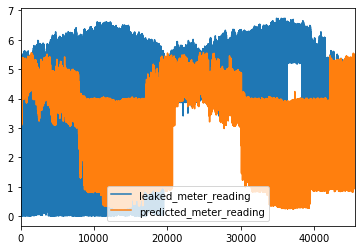

In [41]:
both[both['building_id'].eq(260)][['leaked_meter_reading','predicted_meter_reading']].reset_index(drop=True).plot()

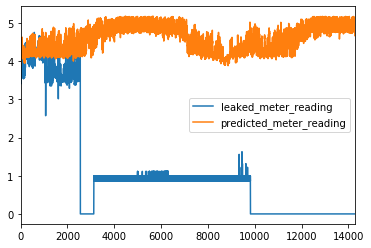

In [36]:
both[both['building_id'].eq(102)][['leaked_meter_reading','predicted_meter_reading']].reset_index(drop=True).plot()

In [ ]:
both.head()